Group assignment: Second-level & ROI analysis
===

Dataset: *Entorhinal grid-like codes and time-locked network dynamics track others navigating through space (Wagner et al., 2022)*

# 0. Setup

## Imports

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
from nipype import config
import os
from os.path import join as opj, abspath
import numpy as np
import pandas as pd
from nilearn import datasets, plotting, image, surface
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import resample_to_img
import re
from nltools.mask import create_sphere
from pprint import pprint
import pickle
import nibabel as nib  # for ROI
from nilearn.maskers import NiftiMapsMasker  # for ROI
from scipy.stats import ttest_1samp  # for ROI

import warnings

warnings.simplefilter("ignore", UserWarning)

template = datasets.load_mni152_template(resolution=1)

config.update_config(
    {
        "logging": {"workflow_level": "INFO"},
        "execution": {
            "stop_on_first_crash": "True",
            "hash_method": "content",
            "remove_unnecessary_outputs": "True",
        },
    }
)

contrast_dir_dict = {
    "navigation > baseline": "navigation",
    "observation > baseline": "other",
    "observation > navigation": "other-self",
    "?": "self",
    "navigation > observation": "self-other",
}

# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI


## Download data

In [3]:
data_dir = "data_Wagner_NatComms_2022"
data_url = "https://ucloud.univie.ac.at/index.php/s/lxNhTQJ4TbkaLnh/download"

if os.path.exists(data_dir) == False:
    print("Downloading data ...", end="")
    import requests
    from zipfile import ZipFile

    r = requests.get(data_url)
    open("data.zip", "wb").write(r.content)
    print("completed.")
    print("Unzipping data ...", end="")
    with ZipFile("data.zip", "r") as zo:
        zo.extractall()
    zo.close()
    print("completed.")
    print("Removing zipfile ...", end="")
    os.remove("data.zip")
    print("completed.")

else:
    print("Data already downloaded.")

Data already downloaded.


## Functions for cmaps

In [4]:
def get_cmaps(chosen_contrast):
    cmaps_dir = (
        data_dir
        + "/model_m1_contrasts_swratopup/"
        + contrast_dir_dict[chosen_contrast]
        + "-AllSessions"
    )

    cmaps = sorted(
        glob(
            f"{abspath(cmaps_dir)}/**/*.nii",
            recursive=True,
        )
    )

    return cmaps


def check_available(filepath, mat):
    """
    Filter filepaths of cmaps to available data.

    """
    number = re.findall("S[0-9][0-9]_", filepath)[0].replace("S", "").replace("_", "")
    res = "sub-" + number
    res = res in mat.index
    return res

# Second-level analysis

## **A**) Model for `other > self`

### Define data and distance matrix

In [5]:
chosen_contrast = "observation > navigation"

cmaps = get_cmaps(chosen_contrast)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix.head()


There are 59 contrast maps


,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


In [6]:
second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

other_self = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="stat", second_level_stat_type="t"
)

## Correcting multiple comparisons

<div class="alert alert-warning">Do we need the complete image with all the negative activations for calculating the threshold?</div>

### Thresholded map

In [7]:
thresholded_map, threshold = threshold_stats_img(
    other_self, alpha=0.001, height_control="fdr", cluster_threshold=91, two_sided=True
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)

The FDR=.001 threshold is 3.541


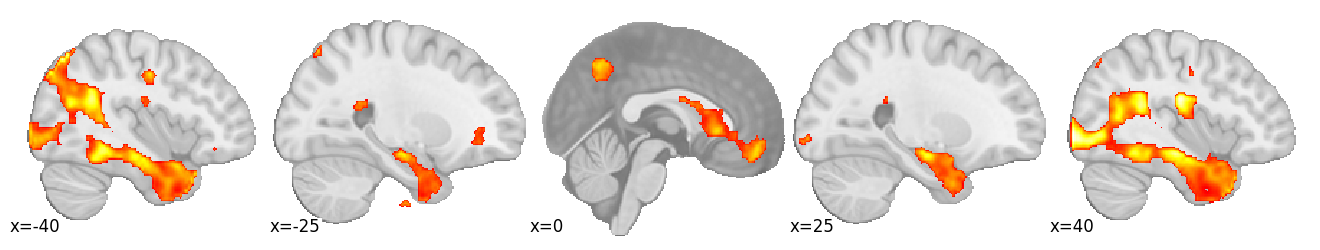

In [8]:
fig = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

fig.savefig("figure_01.png", dpi=300)

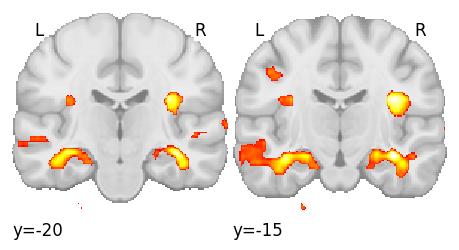

In [9]:
fig = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)
fig.savefig("figure_02.png", dpi=300)

## Surface plots

In [10]:
# for higher resolution
big_fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
big_texture_r = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_right)
big_texture_l = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_left)


Dataset created in /root/nilearn_data/fsaverage



Downloaded 27197440 of 28905506 bytes (94.1%,    0.2s remaining) ...done. (6 seconds, 0 min)
Extracting data from /root/nilearn_data/fsaverage/5592d63c5c8039b4f902396c128dcd85/download..... done.


### Multiple views

with higher resolution (`surf_mesh` argument)

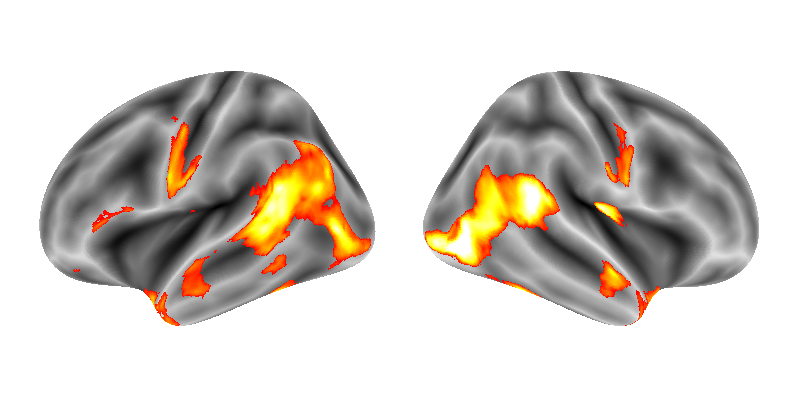

In [11]:
fig, ax = plotting.plot_img_on_surf(
    thresholded_map_pos,
    surf_mesh=big_fsaverage,
    views=["lateral"],
    hemispheres=["left", "right"],
    threshold=threshold,
    colorbar=False,
    inflate=True,
    vmax=10,
)

fig.savefig(
    "figure_surface_01.png",
    pad_inches=0,
    bbox_inches="tight",
    transparent=True,
    dpi=300,
)

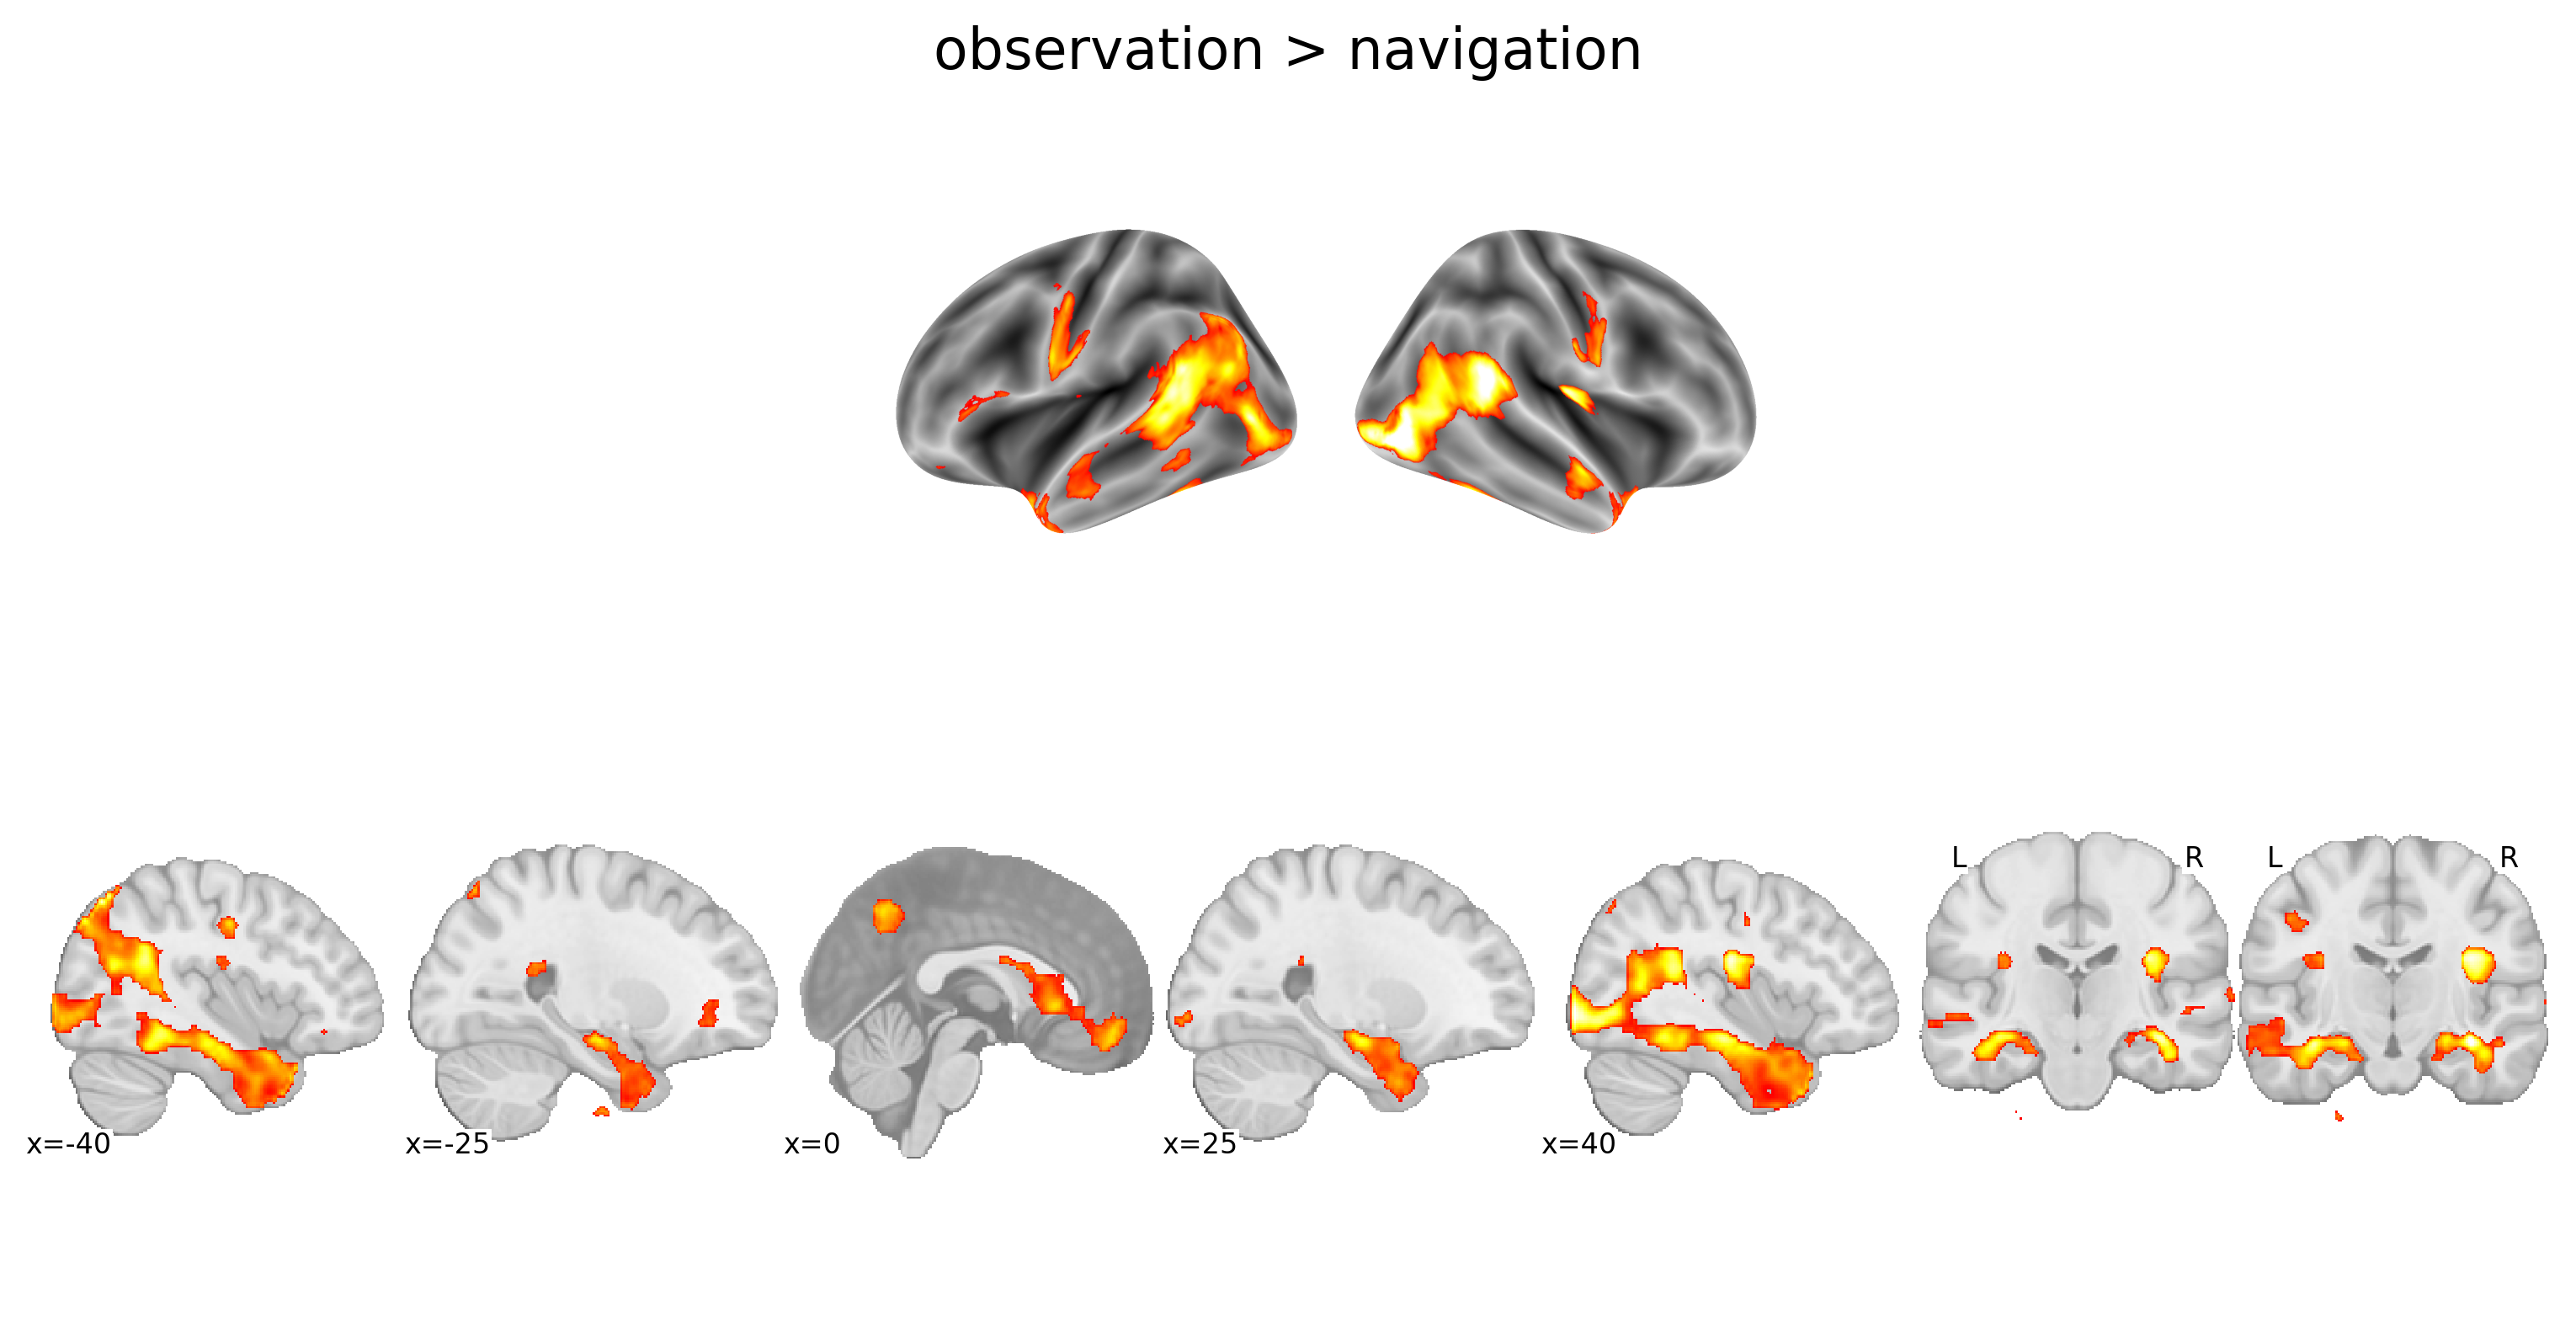

In [12]:
# create figure

fig = plt.figure(figsize=(10, 5.2), dpi=300)
#  rc('font', size=8)

# first row: surface plot

plot_upper = fig.add_subplot(2, 1, 1)
figure_surface = plt.imread("figure_surface_01.png")
plot_upper = plt.imshow(figure_surface)
plot_upper.axes.set_axis_off()

# second row, left:

plot_left = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0, 0, 0.75, 0.48),  # axes = (xmin, ymin, width, height)
)

plot_left.annotate(left_right=False, positions=True, size=8, scale_loc="center")

# second row, right:

plot_right = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0.75, 0, 0.25, 0.48),
)

plot_right.annotate(left_right=True, positions=False, size=8, scale_loc="center")

# set title

fig.suptitle(chosen_contrast, fontsize=16)

# save figure

fig.savefig(
    "figure_complete_01.png", transparent=True, pad_inches=0, bbox_inches="tight"
)

## **B**) Model for `self > other`

### Define data and distance matrix

In [13]:
chosen_contrast = "navigation > observation"

cmaps = get_cmaps(chosen_contrast)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix.head()


There are 59 contrast maps


,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


In [14]:
second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

other_self = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="stat", second_level_stat_type="t"
)

## Correcting multiple comparisons

<div class="alert alert-warning">Do we need the complete image with all the negative activations for calculating the threshold?</div>

### Thresholded map

In [15]:
thresholded_map, threshold = threshold_stats_img(
    other_self, alpha=0.001, height_control="fdr", cluster_threshold=91, two_sided=True
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)

The FDR=.001 threshold is 3.541


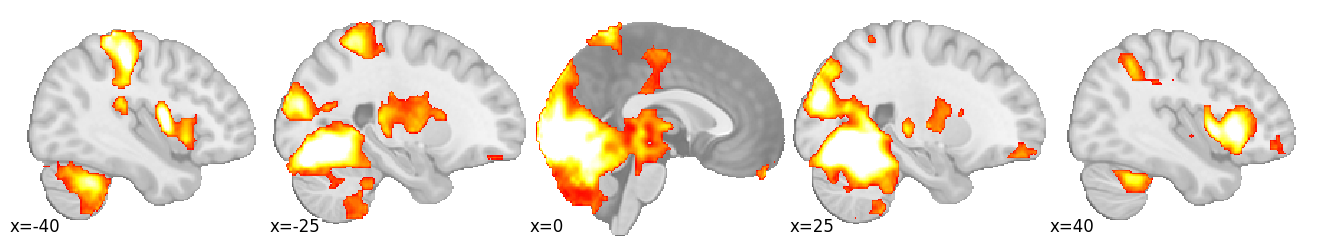

In [16]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

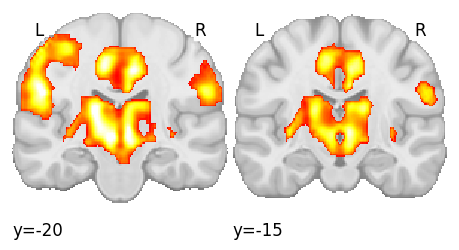

In [17]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

## Surface plots

In [18]:
# for higher resolution
big_fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
big_texture_r = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_right)
big_texture_l = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_left)

### Multiple views

with higher resolution (`surf_mesh` argument)

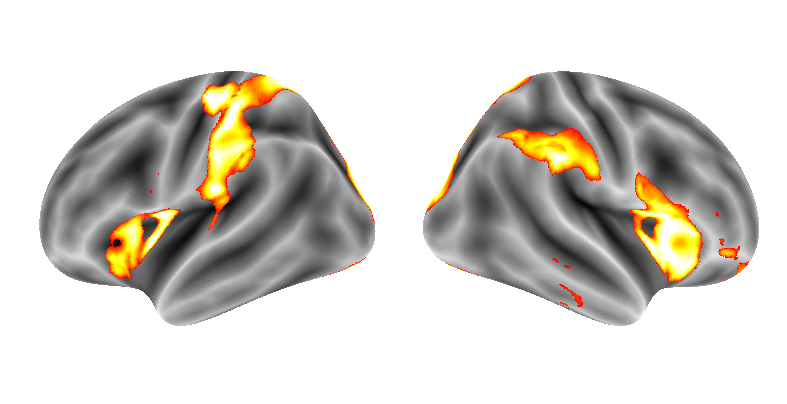

In [19]:
fig, ax = plotting.plot_img_on_surf(
    thresholded_map_pos,
    surf_mesh=big_fsaverage,
    views=["lateral"],
    hemispheres=["left", "right"],
    threshold=threshold,
    colorbar=False,
    inflate=True,
    vmax=10,
)

fig.savefig(
    "figure_surface_02.png",
    pad_inches=0,
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## Multiplot figure

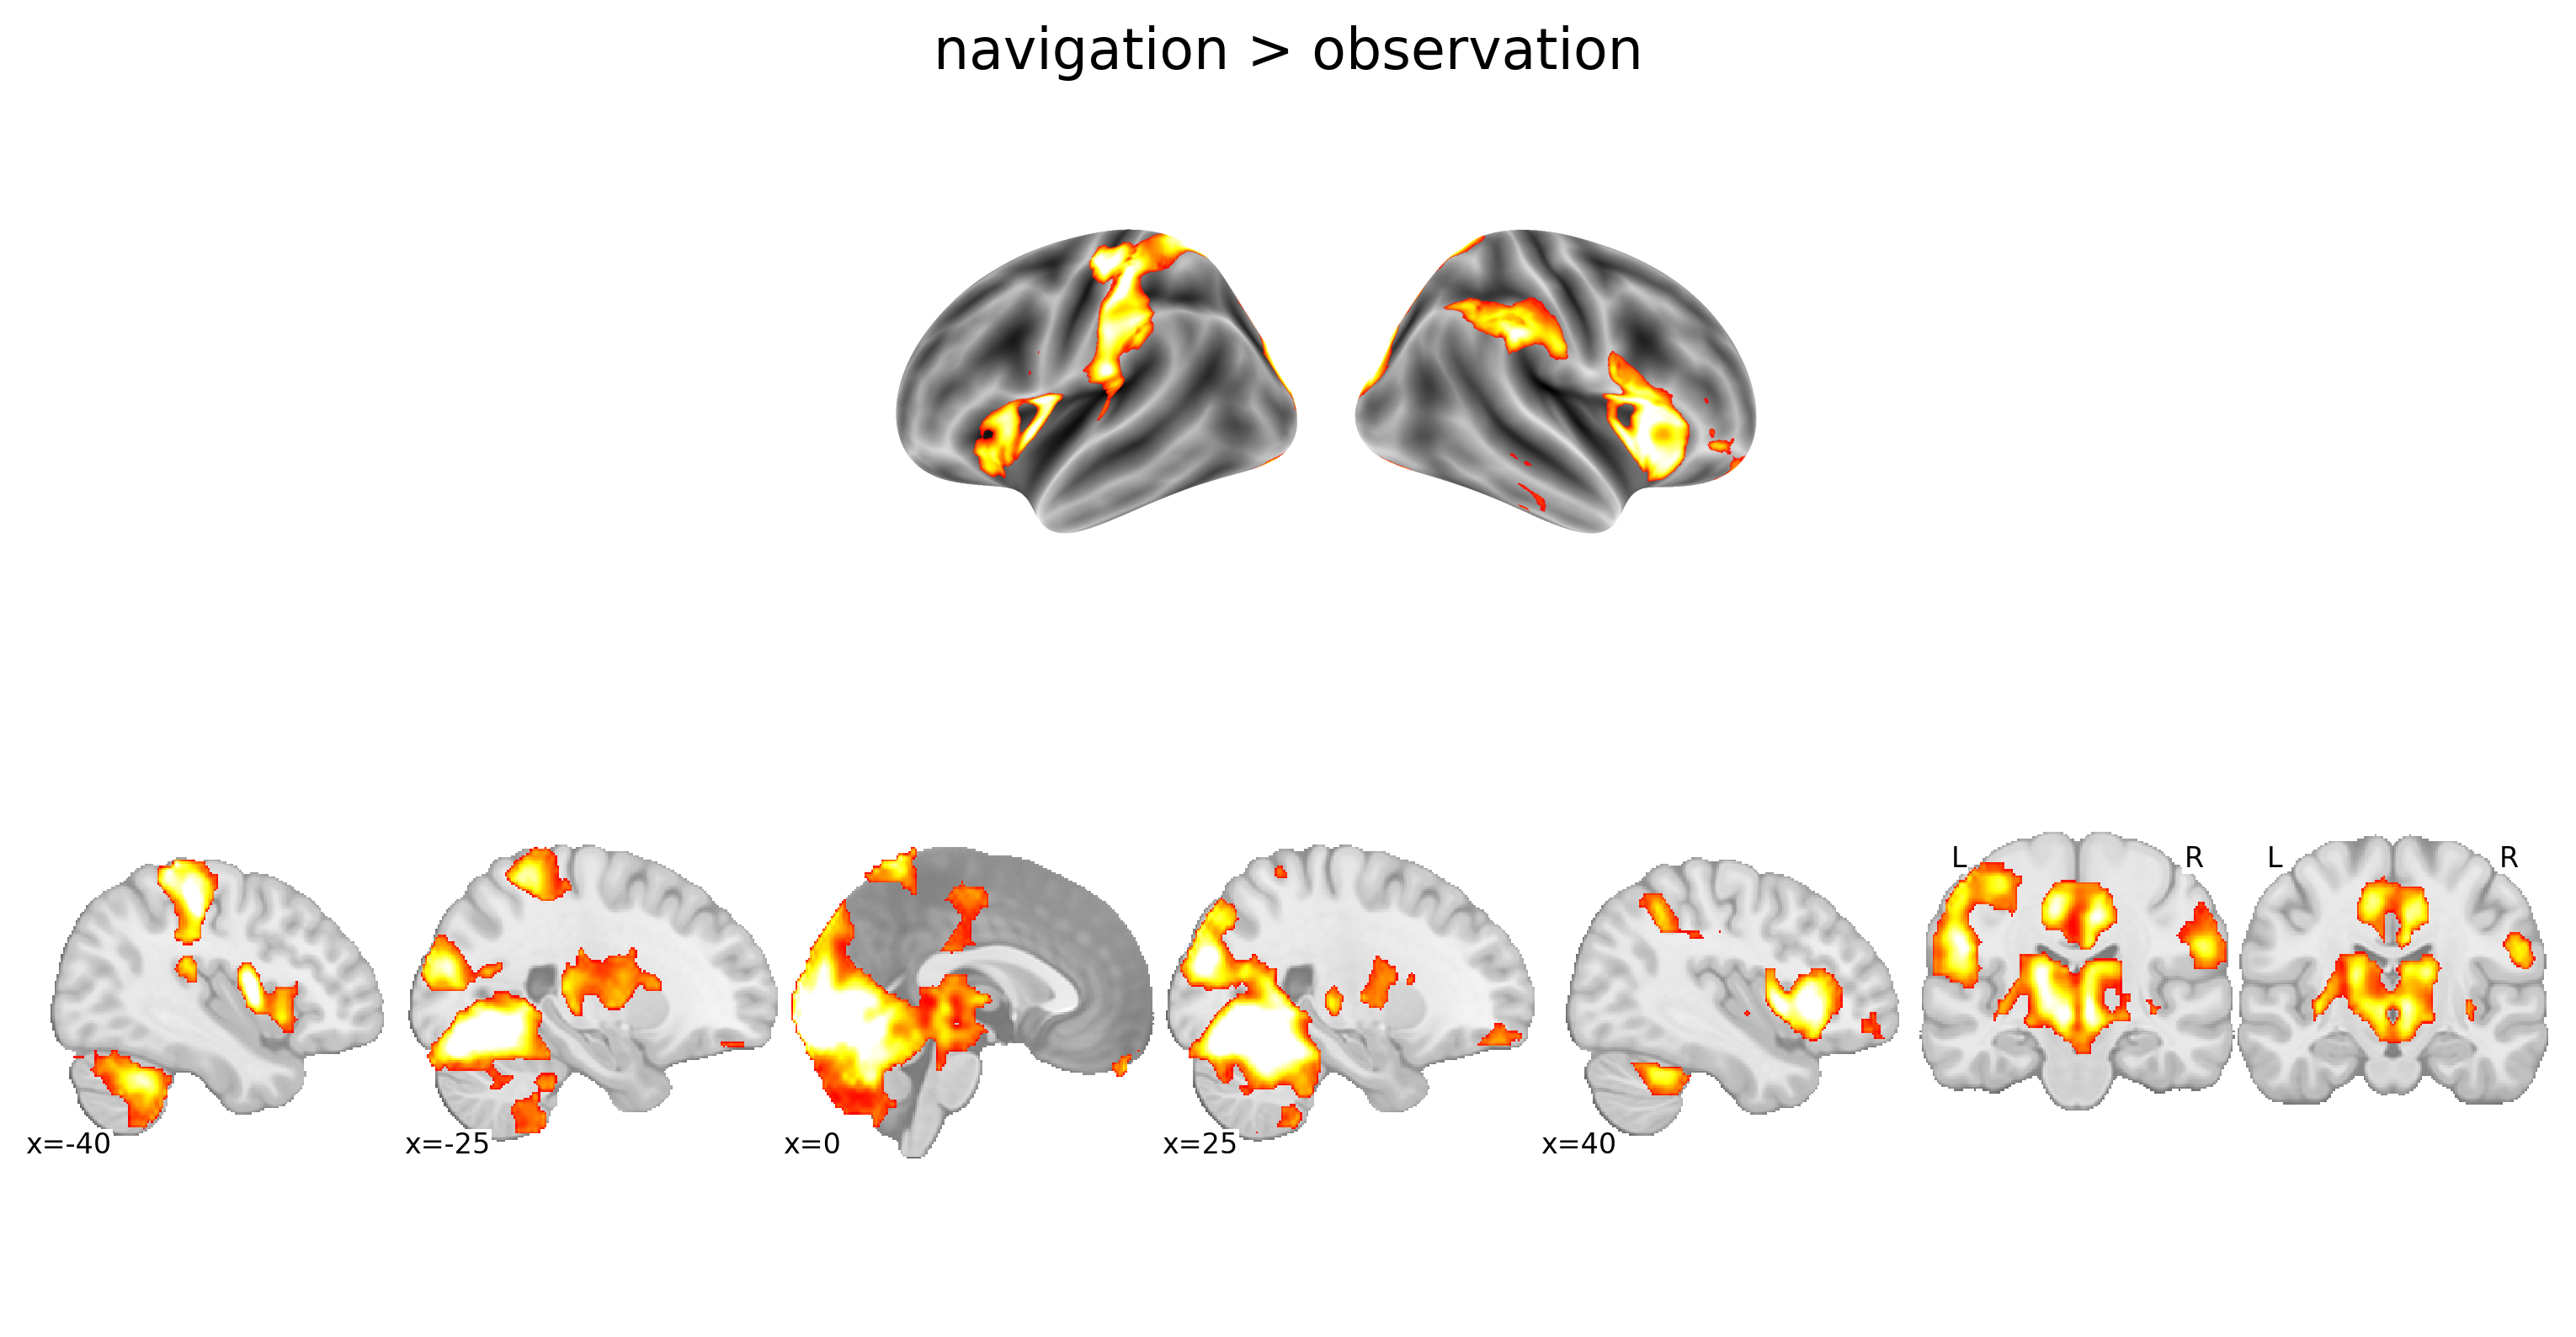

In [20]:
# create figure

fig = plt.figure(figsize=(10, 5.2), dpi=300)
#  rc('font', size=8)

# first row: surface plot

plot_upper = fig.add_subplot(2, 1, 1)
figure_surface = plt.imread("figure_surface_02.png")
plot_upper = plt.imshow(figure_surface)
plot_upper.axes.set_axis_off()

# second row, left:

plot_left = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0, 0, 0.75, 0.48),  # axes = (xmin, ymin, width, height)
)

plot_left.annotate(left_right=False, positions=True, size=8, scale_loc="center")

# second row, right:

plot_right = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0.75, 0, 0.25, 0.48),
)

plot_right.annotate(left_right=True, positions=False, size=8, scale_loc="center")

# set title

fig.suptitle(chosen_contrast, fontsize=16)

# save figure

fig.savefig(
    "figure_complete_02.png",
    pad_inches=0,
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## **C)** Glass brain plot for contrast `observation > baseline * cumulative distance error (vm)`

### Define data and distance matrix

In [21]:
chosen_contrast = "observation > baseline"

cmaps = get_cmaps(chosen_contrast)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]


There are 59 contrast maps


In [22]:
# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

dist_err = pd.read_excel("data_Wagner_NatComms_2022/avgDistErr_20210408.xlsx")
dist_err["subjn"] = "sub-" + dist_err["subjn"].astype(str).str.zfill(2)
dist_err = dist_err.set_index("subjn")

design_matrix = design_matrix.merge(
    dist_err["mean"], left_index=True, right_index=True
).rename(columns={"mean": "distance_error"})

design_matrix.head()

,intercept,distance_error
sub-01,1,19.41951
sub-02,1,26.60407
sub-03,1,10.69242
sub-04,1,27.78675
sub-05,1,14.30383


<div class="alert alert-warning">How to correctly specify the interaction?</div>

The FDR=.001 threshold is 3.919


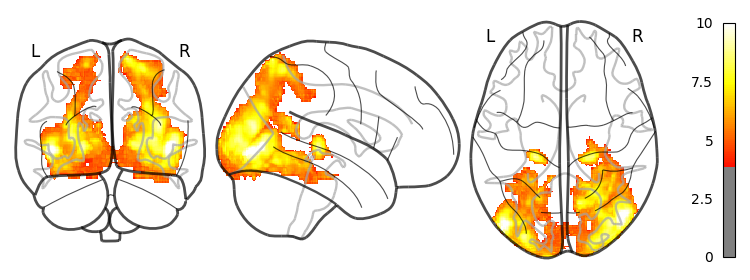

In [23]:
cmaps_filtered = [cm for cm in cmaps if check_available(cm, design_matrix)]

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps_filtered, design_matrix=design_matrix)

other_baseline = second_level.compute_contrast(
    second_level_contrast="intercept + distance_error",
    output_type="stat",
    second_level_stat_type="t",
)

thresholded_map, threshold = threshold_stats_img(
    other_baseline,
    alpha=0.001,
    height_control="fdr",
    cluster_threshold=80,
    two_sided=True,
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)


fig = plotting.plot_glass_brain(
    thresholded_map_pos,
    threshold=threshold,
    colorbar=True,
    vmax=10,
    cmap="cold_hot",
)

# save figure

fig.savefig(
    "figure_glass_03.png",
    dpi=300,
    # transparent=True,
)

# 2. Store objects

Save

Load the already fitted object

As we have pickled the already fitted object, we can go ahead and evaluate some contrasts (without fitting the model again):

# 3. ROI Analysis

Candidates:

* [ ] Entorhinal grid cells
* [x] Hippocampus
* [x] rPPC 
* [ ] Medial temporal lobe

In [24]:
chosen_contrast = "observation > navigation"

## Hippocampus

Pre-defined mask from www.neurovault.org

In [25]:
if os.path.exists("thresh_hippocampus_body_bothsides.nii.gz") == False:
    !wget "https://neurovault.org/media/images/2381/thresh_hippocampus_body_bothsides.nii.gz"
else:
    print("Mask already downloaded.")

hipp_mask = nib.load("thresh_hippocampus_body_bothsides.nii.gz")

Mask already downloaded.


Deterministic mask

In [26]:
if os.path.exists("bHipp.nii.gz") == False:
    !wget "https://neurovault.org/media/images/8079/bHipp.nii.gz"
else:
    print("Mask already downloaded.")


# hipp_mask = nib.load("thresh_hippocampus_body_bothsides.nii.gz")
hipp_mask = nib.load("bHipp.nii.gz")

print(f"shape of the mask: {hipp_mask.shape}")

Mask already downloaded.
shape of the mask: (181, 217, 181)


/usr/local/lib/python3.10/dist-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


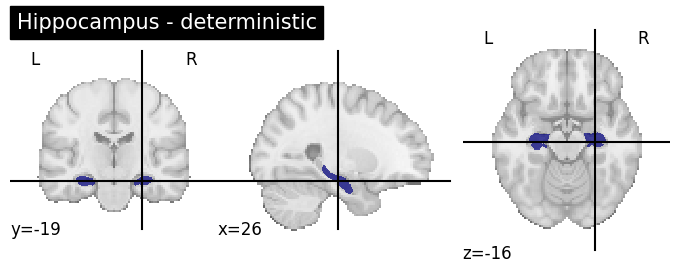

In [27]:
# plotting.plot_roi(hipp_mask, title="Hippocampus - probabilistic")
# plotting.plot_roi(image.binarize_img(hipp_mask, "10%"), title="Hippocampus - binarized")

plotting.plot_roi(hipp_mask, title="Hippocampus - deterministic")

# save to file without a title
plotting.plot_roi(hipp_mask, output_file="figure_mask_hipp.png")

## Extract ROI data from contrast maps 

In [28]:
def extract_roi(cmaps, mask, threshold=None):
    """

    extract mean roi activation from contrast map

    Input:
    - List of contract maps
    - mask
    - threshold: only for probabilistic maps


    """

    if threshold != None:
        mask = image.binarize_img(mask, threshold)

    # instantiate numpy array to store results
    out = np.zeros(len(cmaps))

    # setup masker
    masker = NiftiMapsMasker(mask)

    # loop over subjects
    for i, cmap in enumerate(cmaps):
        print(f"processing subject {i+1} ...", end="")
        out[i] = masker.fit_transform(cmap)
        print("done")

    return out


hipp_means = extract_roi(get_cmaps(chosen_contrast), hipp_mask)

processing subject 1 ...done
processing subject 2 ...done
processing subject 3 ...done
processing subject 4 ...done
processing subject 5 ...done
processing subject 6 ...done
processing subject 7 ...done
processing subject 8 ...done
processing subject 9 ...done
processing subject 10 ...done
processing subject 11 ...done
processing subject 12 ...done
processing subject 13 ...done
processing subject 14 ...done
processing subject 15 ...done
processing subject 16 ...done
processing subject 17 ...done
processing subject 18 ...done
processing subject 19 ...done
processing subject 20 ...done
processing subject 21 ...done
processing subject 22 ...done
processing subject 23 ...done
processing subject 24 ...done
processing subject 25 ...done
processing subject 26 ...done
processing subject 27 ...done
processing subject 28 ...done
processing subject 29 ...done
processing subject 30 ...done
processing subject 31 ...done
processing subject 32 ...done
processing subject 33 ...done
processing subject 

In [29]:
ttest_1samp(hipp_means, 0, alternative="greater")

Ttest_1sampResult(statistic=4.3427034796107264, pvalue=2.8618931496517926e-05)

<div class="alert alert-info">Activation in ROI is significantly greater in the observation than in the navigation condition.</div>

## Right Superior Parietal Lobule (rSPL)
as a proxy for the right posterior parietal cortex (rPPC)

Probabilistic mask from atlas


Dataset created in /root/nilearn_data/fsl



Downloaded 18833408 of 25716861 bytes (73.2%,    0.7s remaining) ...done. (4 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/5773476bc39a2b9db39a7b1dc2e99356/HarvardOxford.tgz..... done.


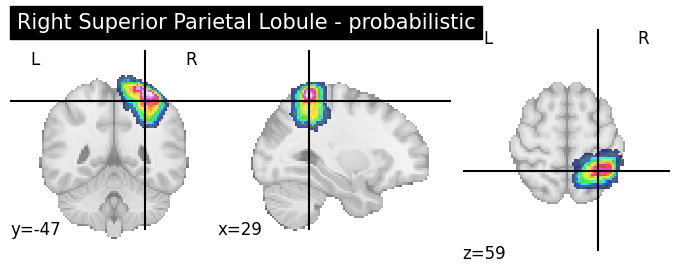

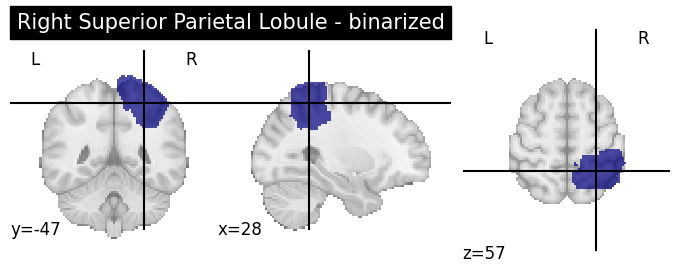

In [30]:
atlas = datasets.fetch_atlas_harvard_oxford(
    "cortl-prob-2mm"
)  #  'Right Superior Parietal Lobule'
roi = "Right Superior Parietal Lobule"

roi_idx = atlas.labels.index(roi) - 1
pc_mask = image.index_img(atlas.maps, index=roi_idx)
plotting.plot_roi(pc_mask, title=roi + " - probabilistic")
plotting.plot_roi(image.binarize_img(pc_mask, "10%"), title=roi + " - binarized")

# save to file without a title
plotting.plot_roi(image.binarize_img(pc_mask, "10%"), output_file="figure_mask_pc.png")

## Extract ROI data from contrast maps `observation > navigation`

In [31]:
pc_means = extract_roi(get_cmaps(chosen_contrast), pc_mask)

processing subject 1 ...done
processing subject 2 ...done
processing subject 3 ...done
processing subject 4 ...done
processing subject 5 ...done
processing subject 6 ...done
processing subject 7 ...done
processing subject 8 ...done
processing subject 9 ...done
processing subject 10 ...done
processing subject 11 ...done
processing subject 12 ...done
processing subject 13 ...done
processing subject 14 ...done
processing subject 15 ...done
processing subject 16 ...done
processing subject 17 ...done
processing subject 18 ...done
processing subject 19 ...done
processing subject 20 ...done
processing subject 21 ...done
processing subject 22 ...done
processing subject 23 ...done
processing subject 24 ...done
processing subject 25 ...done
processing subject 26 ...done
processing subject 27 ...done
processing subject 28 ...done
processing subject 29 ...done
processing subject 30 ...done
processing subject 31 ...done
processing subject 32 ...done
processing subject 33 ...done
processing subject 

In [32]:
ttest_1samp(pc_means, 0, alternative="less")

Ttest_1sampResult(statistic=-3.5328137041449406, pvalue=0.0004071002141175324)

<div class="alert alert-info">Activation in ROI is significantly smaller in the observation than in the navigation condition.</div>

## Plotting ROI results

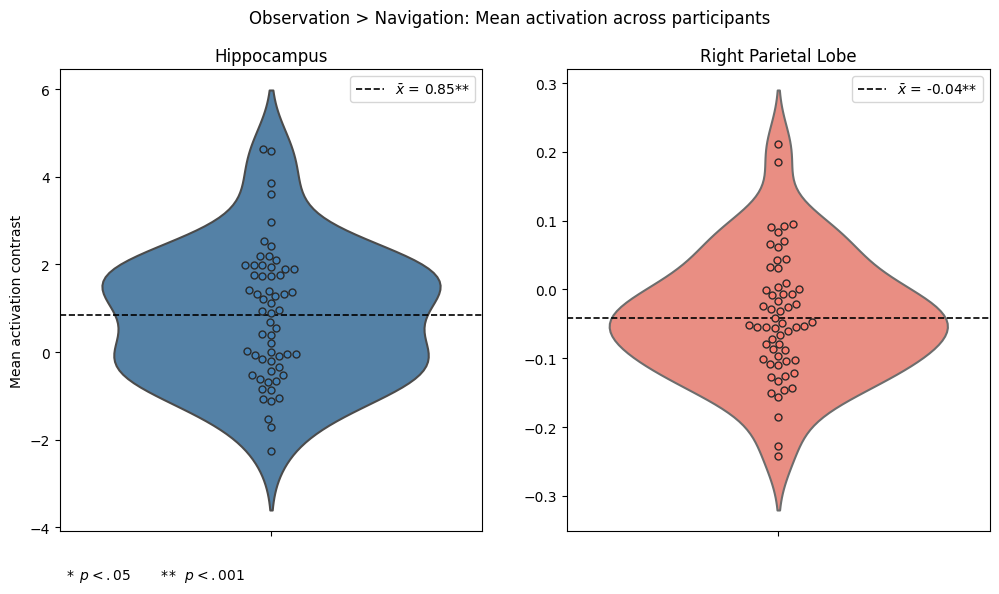

In [33]:
def p_to_stars(p_val):
    """

    Takes in p-value and returns
    significance-asterisks

    """
    if p_val < 0.001:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return ""


_, p1 = ttest_1samp(hipp_means, 0, alternative="greater")
_, p2 = ttest_1samp(pc_means, 0, alternative="less")


# figure for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot 1
ax1s = sns.swarmplot(
    y=hipp_means, color="steelblue", ax=axs[0], edgecolor="#2b2b2b", linewidth=1
)
ax1 = sns.violinplot(y=hipp_means, color="steelblue", ax=axs[0], inner=None)

ax1.axhline(
    np.mean(hipp_means),
    label="$x̄ $ = " + f"{np.mean(hipp_means):.2f}{p_to_stars(p1)}",
    color="black",
    linestyle="--",
    lw=1.2,
)
ax1.set_title("Hippocampus")
ax1.set_ylabel("Mean activation contrast")
ax1.legend()

# plot 2
ax2s = sns.swarmplot(
    y=pc_means, color="salmon", ax=axs[1], edgecolor="#2b2b2b", linewidth=1
)
ax2 = sns.violinplot(y=pc_means, color="salmon", ax=axs[1], inner=None)
ax2.axhline(
    np.mean(pc_means),
    label="$x̄ $ = " + f"{np.mean(pc_means):.2f}{p_to_stars(p2)}",
    color="black",
    linestyle="--",
    lw=1.2,
)
ax2.set_title("Right Parietal Lobe")
ax2.legend()
fig.suptitle("Observation > Navigation: Mean activation across participants")
fig.text(
    0.13,
    0.05,
    r"$* \hspace{0.5} p < .05 \hspace{2} * \hspace{-0.3} * \hspace{0.5} p < .001$",
    va="top",
    ha="left",
    fontsize=10,
)
fig.savefig("figure_roi_violins.png", dpi=200)

Alternative plot

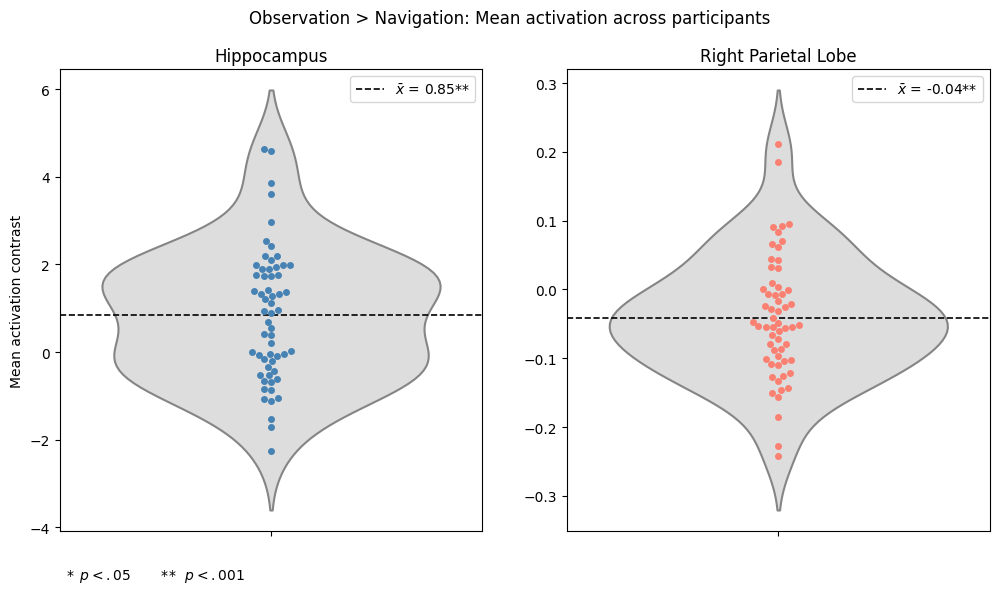

In [34]:
# figure for both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot 1
ax1s = sns.swarmplot(
    y=hipp_means,
    color="steelblue",
    ax=axs[0],
)
ax1 = sns.violinplot(y=hipp_means, color="#dddddd", alpha=0.6, ax=axs[0], inner=None)

ax1.axhline(
    np.mean(hipp_means),
    label="$x̄ $ = " + f"{np.mean(hipp_means):.2f}{p_to_stars(p1)}",
    color="black",
    linestyle="--",
    lw=1.2,
)
ax1.set_title("Hippocampus")
ax1.set_ylabel("Mean activation contrast")
ax1.legend()

# plot 2
ax2s = sns.swarmplot(
    y=pc_means,
    color="salmon",
    ax=axs[1],
)
ax2 = sns.violinplot(y=pc_means, color="#dddddd", alpha=0.6, ax=axs[1], inner=None)
ax2.axhline(
    np.mean(pc_means),
    label="$x̄ $ = " + f"{np.mean(pc_means):.2f}{p_to_stars(p2)}",
    color="black",
    linestyle="--",
    lw=1.2,
)
ax2.set_title("Right Parietal Lobe")
ax2.legend()
fig.suptitle("Observation > Navigation: Mean activation across participants")
fig.text(
    0.13,
    0.05,
    r"$* \hspace{0.5} p < .05 \hspace{2} * \hspace{-0.3} * \hspace{0.5} p < .001$",
    va="top",
    ha="left",
    fontsize=10,
)
fig.savefig("figure_roi_violins.png", dpi=200)

## Correlation between performance (distance error) and the activations in the two ROIs

### `observation > baseline`

In [37]:
chosen_contrast = "observation > baseline"

hipp_means_self = extract_roi(get_cmaps(chosen_contrast), hipp_mask)
pc_means_self = extract_roi(get_cmaps(chosen_contrast), pc_mask)

processing subject 1 ...done
processing subject 2 ...done
processing subject 3 ...done
processing subject 4 ...done
processing subject 5 ...done
processing subject 6 ...done
processing subject 7 ...done
processing subject 8 ...done
processing subject 9 ...done
processing subject 10 ...done
processing subject 11 ...done
processing subject 12 ...done
processing subject 13 ...done
processing subject 14 ...done
processing subject 15 ...done
processing subject 16 ...done
processing subject 17 ...done
processing subject 18 ...done
processing subject 19 ...done
processing subject 20 ...done
processing subject 21 ...done
processing subject 22 ...done
processing subject 23 ...done
processing subject 24 ...done
processing subject 25 ...done
processing subject 26 ...done
processing subject 27 ...done
processing subject 28 ...done
processing subject 29 ...done
processing subject 30 ...done
processing subject 31 ...done
processing subject 32 ...done
processing subject 33 ...done
processing subject 

create dataframe

In [38]:
dist_err["hipp"] = hipp_means_self
dist_err["spl"] = pc_means_self
dist_err = dist_err.rename(columns={"mean": "distance_error"})
dist_err = dist_err[["hipp", "spl", "distance_error"]]

outlier removal

In [39]:
from scipy import stats

dist_err["z_distance_error"] = stats.zscore(dist_err["distance_error"])
dist_err = dist_err.loc[dist_err.z_distance_error < 3]

correlations

In [40]:
from scipy.stats import pearsonr

corr_r_hipp, corr_p_hipp = pearsonr(dist_err.hipp, dist_err.distance_error)
print("hippocampus roi vs distance error")
print("r =", corr_r_hipp)
print("p =", corr_p_hipp)

print("\nrSPL roi vs distance error")
corr_r_spl, corr_p_spl = pearsonr(dist_err.spl, dist_err.distance_error)
print("r =", corr_r_spl)
print("p =", corr_p_spl)

hippocampus roi vs distance error
r = -0.05243151001994323
p = 0.6958836195816472

rSPL roi vs distance error
r = -0.3736062854083168
p = 0.0038675889556725727


<AxesSubplot:>

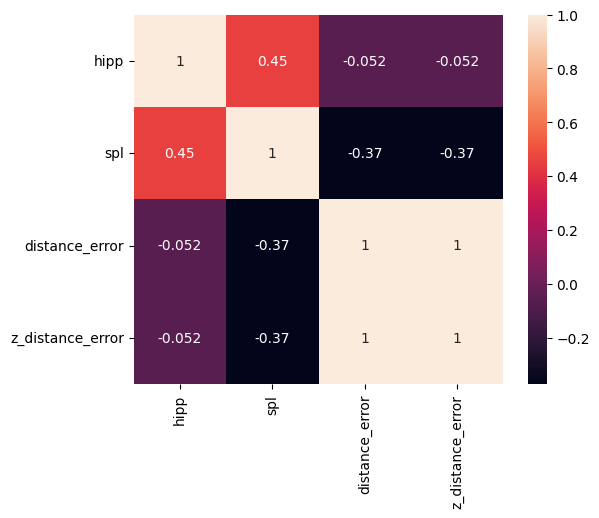

In [41]:
sns.heatmap(dist_err.corr(), square=True, annot=True)

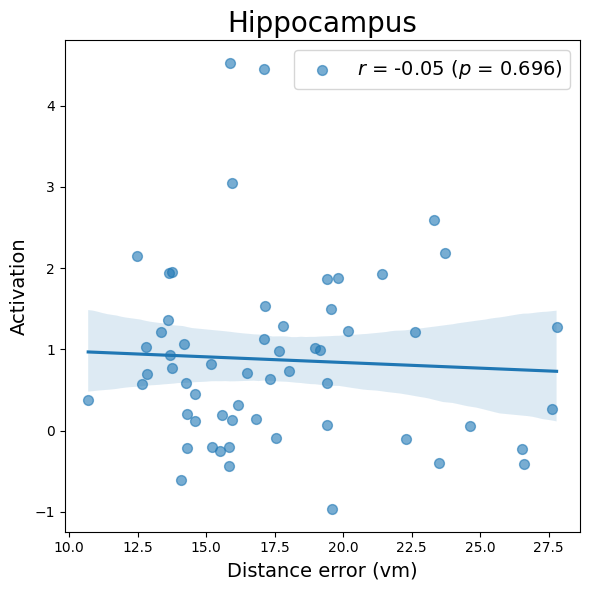

In [79]:
plt.figure(figsize=(6, 6))
sns.regplot(
    data=dist_err,
    x="distance_error",
    y="hipp",
    label=f"$r$ = {corr_r_hipp:.2f} ($p$ = {corr_p_hipp:.3f})",
    scatter_kws=dict(s=50, alpha=0.6),
)
plt.ylabel("Activation", fontsize=14)
plt.xlabel("Distance error (vm)", fontsize=14)
plt.title("Hippocampus", fontsize=20)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(
    "figure_hipp_perf.png",
    dpi=200,
    transparent=True,
    facecolor="white",
    edgecolor="black",
)

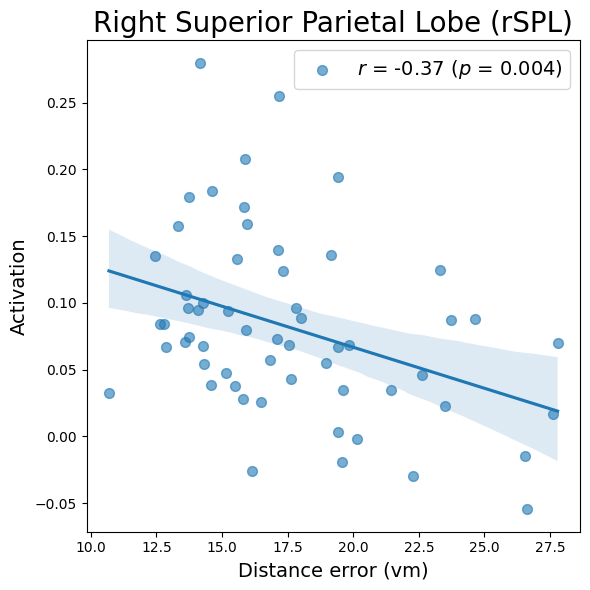

In [80]:
fig = plt.figure(figsize=(6, 6))
sns.regplot(
    data=dist_err,
    x="distance_error",
    y="spl",
    label=f"$r$ = {corr_r_spl:.2f} ($p$ = {corr_p_spl:.3f})",
    scatter_kws=dict(s=50, alpha=0.6),
)
plt.ylabel("Activation", fontsize=14)
plt.xlabel("Distance error (vm)", fontsize=14)
plt.title("Right Superior Parietal Lobe (rSPL)", fontsize=20)
plt.legend(fontsize=14)
fig.tight_layout()
fig.savefig(
    "figure_rspl_perf.png",
    dpi=200,
    transparent=True,
    facecolor="white",
    edgecolor="black",
)

There are moderate correlations: The higher the brain activation in the observation task compared to baseline the lower the distance error.

This is only signficant in the rSPL, but not the Hippocampus.